In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import optimizers, regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, Convolution2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from random import randint

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import os

#### Load in the Datasets

In [3]:
x_train = np.load("trnImage.npy")
y_train = np.load("trnLabel.npy")
x_test = np.load("tstImage.npy")
y_test = np.load("tstLabel.npy")

#reshape data for tf model
x_train = x_train.transpose(3,0,1,2)
x_test = x_test.transpose(3,0,1,2)

classNames = np.unique(y_train)

#### Visualise data to check we are loading in correctly

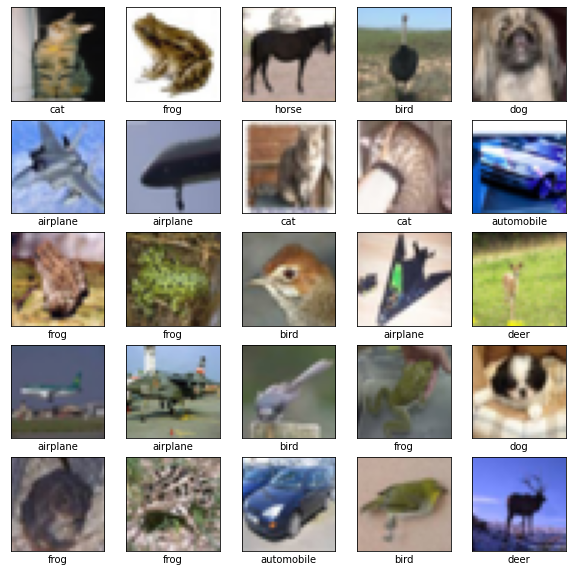

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    j = randint(0,8000)
    image = x_train[j,:, :, :]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[j,:, :, :], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[j,:][0]])
plt.show()

#### Create train test split data for testing and validation 

In [5]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2)

print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_val.shape, Y_val.shape))

Train: X=(10000, 32, 32, 3), y=(10000, 1)
Test: X=(1000, 32, 32, 3), y=(1000, 1)
Train: X=(8000, 32, 32, 3), y=(8000, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


#### CNN Model Creation

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10))
print(model.summary())

model.compile(optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, Y_train, epochs=20, steps_per_epoch=250,
                    validation_data=(X_val, Y_val), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0

16/16 [==============================] - 0s 5ms/step - loss: 1.2118 - accuracy: 0.6205

Test result: 62.050 loss: 1.212


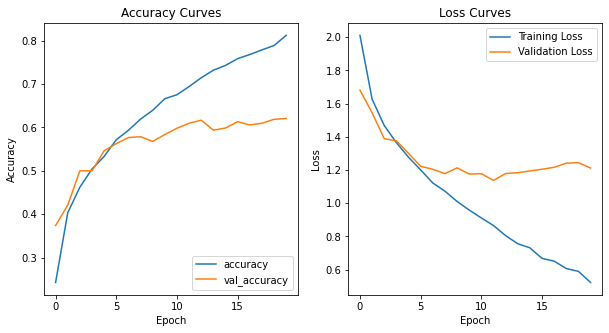

In [7]:
scores = model.evaluate(X_val, Y_val, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()


In [8]:
#method to show better looking version of the confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=70)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Classification report 
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       192
           1       0.75      0.69      0.72       194
           2       0.48      0.60      0.53       201
           3       0.51      0.38      0.43       191
           4       0.58      0.57      0.57       220
           5       0.52      0.57      0.55       195
           6       0.66      0.71      0.68       197
           7       0.74      0.65      0.69       201
           8       0.72      0.70      0.71       227
           9       0.63      0.78      0.70       182

    accuracy                           0.62    

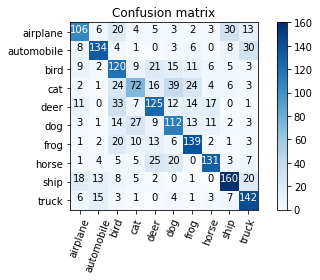

In [9]:
#getting the expected classes from the trained data
yPredict = model.predict_classes(X_val)
yPredictProbs = model.predict(X_val)
Y_val_reshaped =  Y_val.reshape(2000)

print("Classification report \n=======================")
print(classification_report(y_true=Y_val_reshaped, y_pred=yPredict))

cm = confusion_matrix(y_true=Y_val_reshaped, y_pred=yPredict)

plot_confusion_matrix(cm, class_names)